# TTIC 31020 Introduction to Machine Learning: Learning Gaussian Mixture Models with Expectation-Maximization
---

In this notebook you will implement the EM algorithm to train mixtures of Gaussians, with the goal of performing classification on the Fashion MNIST dataset. Fashion MNIST is composed of 28 x 28 grayscale images, split into 50,000 training and 10,000 validation images.

In [1]:
from __future__ import division
import time
from scipy.special import logsumexp  #to deal with potential overflow issues
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import csv
from skimage.transform import resize

%matplotlib inline

class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        
def read_fMNIST(dataset = "training", dim=16):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/validation)
    Dimension: dim specifies the target image dimension (default is to reduce images to 16x16)
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'

    else:
        print("dataset must be 'validation' or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    y = np.load('./y'+file_name_suffix+'.npy')
    
    X = reduceImg(X,dim)
    
    #Return the data
    return X,y
         
            
def showImage(image,ax=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if len(image.shape) > 1:
        n=image.shape[0]
    else:
        n=int(np.sqrt(image.shape[0]))
        image = image[-n**2:]
        image = image.reshape(n,n)

    
    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    

def reduceImg(X,dnew):
    # image size in X is hardcoded = 28 (not best practice!)
    xNew=np.zeros((X.shape[0],dnew*dnew))
    for i in range(X.shape[0]):
        xNew[i]=resize(X[i].reshape(28,28),(dnew,dnew), mode='constant').flatten()
    return xNew

In [2]:
# Load training data
xTrain, yTrain = read_fMNIST('training')
# Load validation data
xVal, yVal = read_fMNIST('validation')

# scale pixel values to [0,1] to make things better-behaved numerically
if xTrain[0].max()>1:
    print('normalizing...')
    xTrain=xTrain/255
    xVal=xVal/255

print(xTrain.shape, xVal.shape)

(50000, 256) (10000, 256)


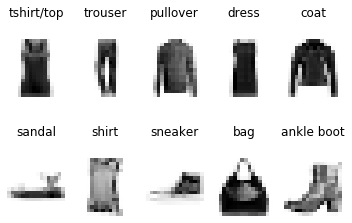

In [3]:
for c in range(10):
    ax=plt.subplot(2,5,c+1)
    ax.clear()
    idx = np.argmax(np.argmax(yTrain,axis=1)==c)
    showImage(xTrain[idx],ax)
    ax.set_title(class_names[c])

In [4]:
class GaussianMixtureModel(object):
    """Gaussian Mixture Model"""
    
    def __init__(self, X, num_comp, max_iter=50, eps=10**(-4), cov_type='diag'):
        """Initialize the GMM model.
        num_feat: Feature dimension of our data
        num_comp: Number of components to fit in the mixture model.
        max_iter: Maximum number of EM iterations.
        cov_type: Type of covariance matrix used by multivariate Gaussian models ('diag': diagonal, otherwise full)
        """
        N,self.nf = X.shape
        self.nc = num_comp
        self.max_iter = max_iter
        self.eps = eps
        self.cov_type = cov_type
        
        # Initialization: feel free to improve this.
        # Note that we are passing the data X so you can use it to try smarter init strategies
        
        # initialize the parameters
        self.pi = np.ones(self.nc) * (1 / self.nc) 

        np.random.shuffle(X)
        X2 = np.array_split(X, self.nc)
        temp = t = [i.mean(axis=0) for i in X2]
        self.mu = np.vstack(t)

        self.sigma = np.zeros((self.nc, self.nf, self.nf))
        for i in range(self.nc):
            self.sigma[i] = np.eye(self.nf) + self.eps
        
    def Estep(self, X):
        """Update the soft weights and calculate likelihood in the process."""
        log_gamma = np.zeros((X.shape[0], self.nc))
        log_pi = np.log(self.pi)
        for comp in range(self.nc):
            
            # put here code you need to compute log_gamma as explained below; everything else will follow
            # this is the unnormalized value of responsibilities, i.e., log ( pi_c*p(x|c) )
            sigma_inv = np.linalg.inv(self.sigma[comp])
            sigma_det = np.linalg.slogdet(self.sigma[comp])[1]
            shift_data = X - self.mu[comp]
            exp_val = np.sum(np.dot(shift_data, sigma_inv) * shift_data, axis=1)
            value = -1/2 * (self.nf * np.log(2*np.pi) + sigma_det) - 1/2 * exp_val
            log_gamma[:, comp] = log_pi[comp] + value

        # now you can use the values of log_gamma to calculate log-likelihood, responsibilities, etc
        log_prob_per_instance = logsumexp(log_gamma, axis=1, keepdims=True)
        log_likelihood = np.mean(log_prob_per_instance)
        gamma = np.exp(log_gamma - log_prob_per_instance)
        return gamma, log_likelihood, log_prob_per_instance
        
    def Mstep(self, X, gamma):
        """Update the model params given the soft weights."""
        # Calculate unnormalized pi with epsilon added to avoid cases where a component gets no instances
        unnorm_pi = np.sum(gamma, axis=0) + self.eps # shape = (nc,);
        # Update the overall soft assignments to different components
        self.pi = unnorm_pi/np.sum(unnorm_pi)
        
        for comp in range(self.nc):
            # Scale the different instances by the soft weight for the current component
            resp_data = np.dot(np.diag(gamma[:, comp]), X)
            # Normalize the responsible data by total soft weight to get mean
            self.mu[comp] = np.sum(resp_data, axis=0)/unnorm_pi[comp]
            
            shift_data = X - self.mu[comp]
            # Captures the multiplication of gamma in covariance calculation
            resp_scaled_shift_data = np.dot(np.diag(gamma[:, comp]), shift_data)
            
            if self.cov_type == 'diag':
                # assume that the covariance matrices are diagonal
                # remember to guard against collapse (sigmas too close to zero)
                self.sigma[comp] = np.sum(resp_scaled_shift_data * shift_data, axis=0)/unnorm_pi[comp] + np.eye(self.nf)*self.eps
            else:
                # do the full rank covariance matrix calculation 
                # here, too, you need to consider some protection against collapsing covariance matrices     
                self.sigma[comp] = np.sum(resp_scaled_shift_data @ shift_data.T)/unnorm_pi[comp] + np.eye(self.nf)*self.eps

    
    def train(self, X,verbose='final'):
        """Train the model using EM."""
        prev_likelihood = -np.inf  # Keep track of previous log likelihood
        gamma, log_likelihood, _ = self.Estep(X)  
        for i in range(self.max_iter):
            self.Mstep(X, gamma)  # M-step
            gamma, log_likelihood, _ = self.Estep(X)  
            if np.isclose(log_likelihood,prev_likelihood):
                # Convergence = no significant increase in likelihood after an iteration.
                # Feel free to try other stopping criteria
                break
            else:
                prev_likelihood = log_likelihood
            if verbose == 'iter':
                print ("   Iteration: %d, log-likelihood: %.4f" %(i, log_likelihood))
            
        if verbose == 'final':
                print ("Iteration %d (final), log-likelihood: %.4f" %(i, log_likelihood))
                
                
    def trainFast(self,X,verbose='final',rs=[.03,.1,.3,1]):
        """
        Train the model using EM, gradually fitting larger portion of the data
        rs specifies the fractions of the full data set size to use
        Note: by making the last elements of rs less than 1 you can effectively train on a subset of data
        (examples past the first r*X.shape[0] won't be seen at all)
        """
        for r in rs:
            self.train(X[0:int(np.floor(X.shape[0]*r))],verbose='final')
        

In [5]:
# organize data by class
classData=dict()
for y in range(10):
    classData[y]=xTrain[np.argmax(yTrain,axis=1)==y]

In [6]:
def get_accuracy(models, X,y):
    """
    Compute accuracy of the GMM generative classifier on (X,y).
    model[c] is the GMM for class c
    Returns (acc, yhat) where yhat are the predictions (in label form)
    """
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        logLik[:,c] = np.squeeze(models[c].Estep(X)[2])
    
    yhat = np.argmax(logLik,axis=1)
    acc = np.mean(yhat==np.argmax(y,axis=1))
    return acc, yhat

In [7]:
def showMeans(gmmModels,c,handles=False):
    """
    Display means for Gaussian components of gmmModels for class c
    """
    k = gmmModels[c].nc
    fig,axes = plt.subplots(1,k)
    
    for j in range(k):
        if k==1:
            ax=axes
        else:
            ax=axes[j]
        showImage(gmmModels[c].mu[j],ax)
        ax.axis('off')
        if j==0:
            ax.set_title(class_names[c]+'/'+str(j))
        else:
            ax.set_title('/'+str(j))
    if handles:
        return fig,axes

Iteration 1 (final), log-likelihood: 25.3441
================ class 0(tshirt/top), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 33.6805
================ class 1(trouser), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 21.6420
================ class 2(pullover), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 27.2816
================ class 3(dress), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 20.5264
================ class 4(coat), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 14.4172
================ class 5(sandal), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 19.7654
================ class 6(shirt), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: 33.8118
================ class 7(sneaker), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood: -8.1486
================ class 8(bag), mixture of 1 diag Gaussians
Iteration 1 (final), log-likelihood:

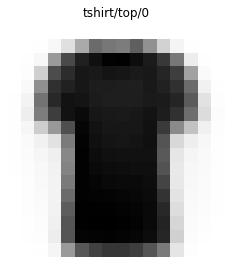

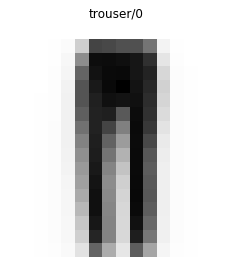

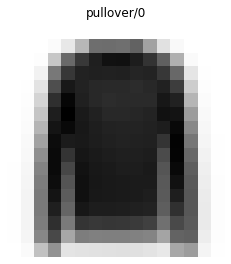

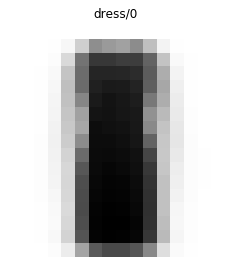

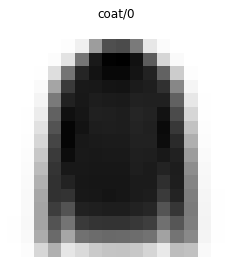

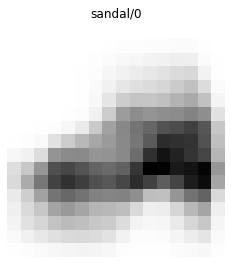

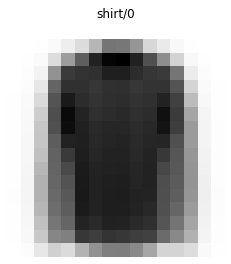

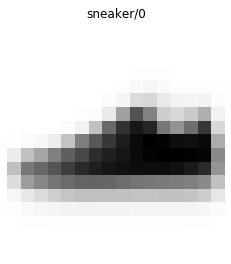

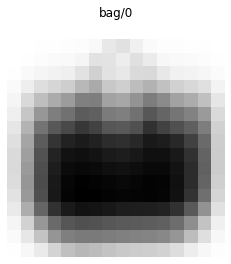

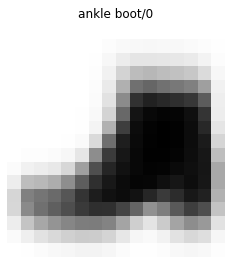

Iteration 20 (final), log-likelihood: 30.5622
Iteration 8 (final), log-likelihood: 31.1831
Iteration 16 (final), log-likelihood: 32.4231
Iteration 19 (final), log-likelihood: 32.1300
================ class 0(tshirt/top), mixture of 3 diag Gaussians
Iteration 26 (final), log-likelihood: 41.6159
Iteration 9 (final), log-likelihood: 40.7885
Iteration 12 (final), log-likelihood: 40.4784
Iteration 5 (final), log-likelihood: 40.0440
================ class 1(trouser), mixture of 3 diag Gaussians
Iteration 37 (final), log-likelihood: 33.0432
Iteration 10 (final), log-likelihood: 31.5003
Iteration 3 (final), log-likelihood: 31.3195
Iteration 21 (final), log-likelihood: 30.4322
================ class 2(pullover), mixture of 3 diag Gaussians
Iteration 5 (final), log-likelihood: 34.8943
Iteration 10 (final), log-likelihood: 35.3505
Iteration 13 (final), log-likelihood: 34.6619
Iteration 12 (final), log-likelihood: 34.4688
================ class 3(dress), mixture of 3 diag Gaussians
Iteration 6 (fi

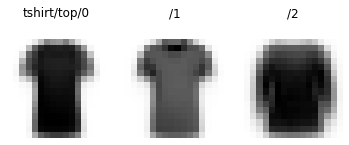

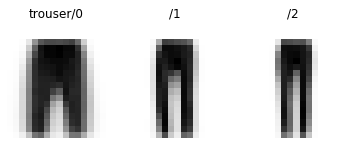

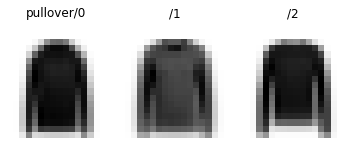

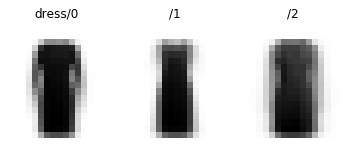

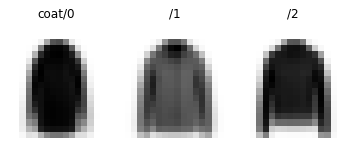

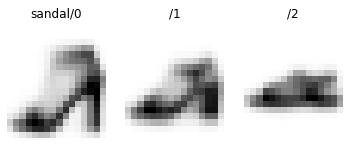

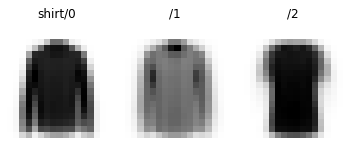

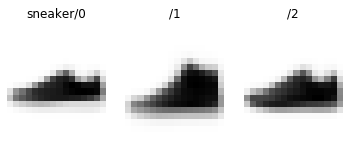

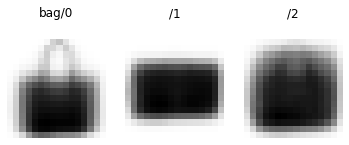

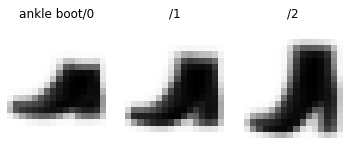

In [10]:
ks=[1,3]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=40, eps=.1,cov_type='diag')
        if k==1:
            rs=[1]
        else:
            rs=[.05,.1,.25,1]    
        mmodels[y].trainFast(classData[y],verbose='final',rs=rs)
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d diag Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-diag (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)

        plt.show()


Iteration 1 (final), log-likelihood: -4885.9239
================ class 0(tshirt/top), mixture of 1 full Gaussians


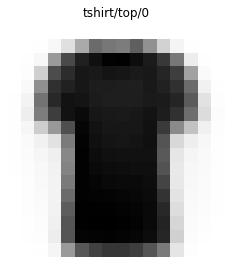

Iteration 1 (final), log-likelihood: -2476.7506
================ class 1(trouser), mixture of 1 full Gaussians


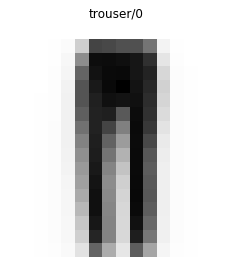

Iteration 1 (final), log-likelihood: -5637.7630
================ class 2(pullover), mixture of 1 full Gaussians


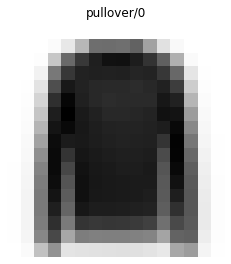

Iteration 1 (final), log-likelihood: -3939.3134
================ class 3(dress), mixture of 1 full Gaussians


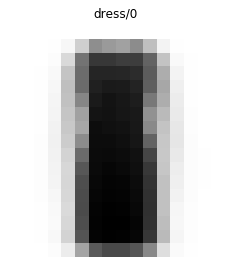

Iteration 1 (final), log-likelihood: -4897.7037
================ class 4(coat), mixture of 1 full Gaussians


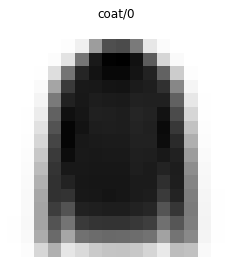

Iteration 1 (final), log-likelihood: -4391.7254
================ class 5(sandal), mixture of 1 full Gaussians


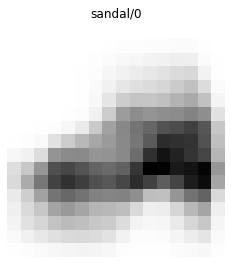

Iteration 1 (final), log-likelihood: -5892.1592
================ class 6(shirt), mixture of 1 full Gaussians


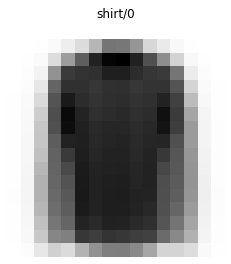

Iteration 1 (final), log-likelihood: -2432.7564
================ class 7(sneaker), mixture of 1 full Gaussians


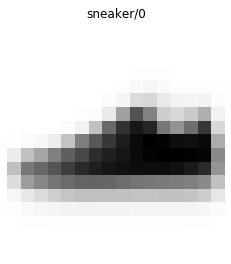

Iteration 1 (final), log-likelihood: -7756.2991
================ class 8(bag), mixture of 1 full Gaussians


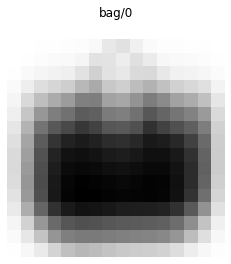

Iteration 1 (final), log-likelihood: -4753.3369
================ class 9(ankle boot), mixture of 1 full Gaussians


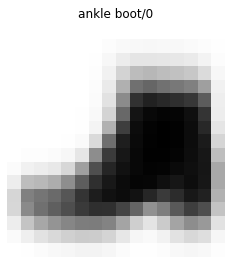

GMM-full (1) accuracy:  0.6737  [ 0.6778 on train]
Iteration 5 (final), log-likelihood: -1856.2943
Iteration 4 (final), log-likelihood: -1871.0064
Iteration 4 (final), log-likelihood: -1982.4026
Iteration 2 (final), log-likelihood: -2041.7836
================ class 0(tshirt/top), mixture of 3 full Gaussians


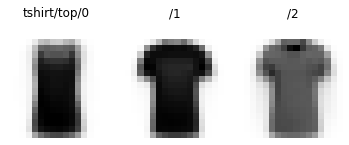

Iteration 8 (final), log-likelihood: -1168.6956
Iteration 11 (final), log-likelihood: -1168.1376
Iteration 8 (final), log-likelihood: -1320.9625
Iteration 4 (final), log-likelihood: -1321.6650
================ class 1(trouser), mixture of 3 full Gaussians


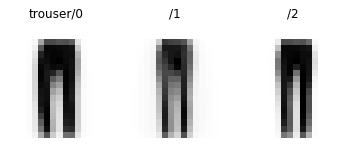

Iteration 6 (final), log-likelihood: -2295.8695
Iteration 10 (final), log-likelihood: -2268.4114
Iteration 5 (final), log-likelihood: -2336.1475
Iteration 5 (final), log-likelihood: -2327.8576
================ class 2(pullover), mixture of 3 full Gaussians


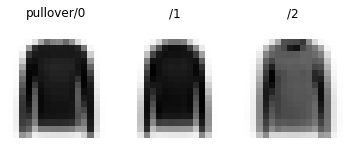

Iteration 11 (final), log-likelihood: -2166.2729
Iteration 5 (final), log-likelihood: -2098.7146
Iteration 8 (final), log-likelihood: -2078.7585
Iteration 5 (final), log-likelihood: -2036.6543
================ class 3(dress), mixture of 3 full Gaussians


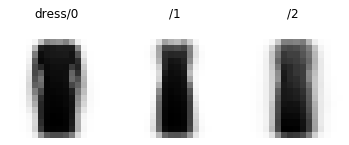

Iteration 5 (final), log-likelihood: -2430.2617
Iteration 29 (final), log-likelihood: -2347.2778
Iteration 7 (final), log-likelihood: -2359.7849
Iteration 4 (final), log-likelihood: -2293.9483
================ class 4(coat), mixture of 3 full Gaussians


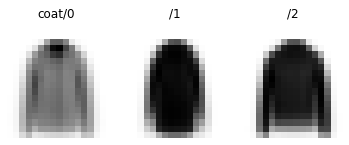

Iteration 11 (final), log-likelihood: -2995.5127
Iteration 12 (final), log-likelihood: -2930.5435
Iteration 3 (final), log-likelihood: -2900.8431
Iteration 8 (final), log-likelihood: -2866.8679
================ class 5(sandal), mixture of 3 full Gaussians


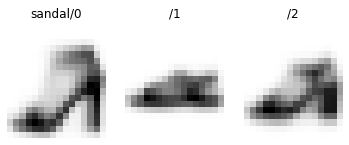

Iteration 9 (final), log-likelihood: -2118.1819
Iteration 3 (final), log-likelihood: -2288.0992
Iteration 2 (final), log-likelihood: -2371.6867
Iteration 2 (final), log-likelihood: -2315.8778
================ class 6(shirt), mixture of 3 full Gaussians


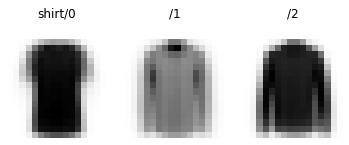

Iteration 13 (final), log-likelihood: -1330.4977
Iteration 8 (final), log-likelihood: -1282.7874
Iteration 3 (final), log-likelihood: -1298.2610
Iteration 3 (final), log-likelihood: -1326.2053
================ class 7(sneaker), mixture of 3 full Gaussians


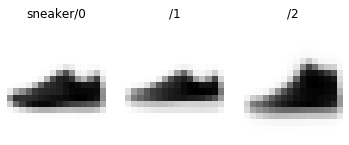

Iteration 8 (final), log-likelihood: -3404.9677
Iteration 6 (final), log-likelihood: -3585.8177
Iteration 6 (final), log-likelihood: -3733.1625
Iteration 4 (final), log-likelihood: -3724.7878
================ class 8(bag), mixture of 3 full Gaussians


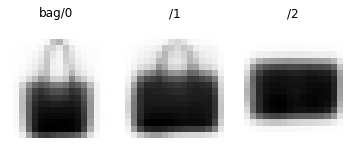

Iteration 8 (final), log-likelihood: -2518.5408
Iteration 4 (final), log-likelihood: -2595.1351
Iteration 2 (final), log-likelihood: -2551.9634
Iteration 7 (final), log-likelihood: -2499.2488
================ class 9(ankle boot), mixture of 3 full Gaussians


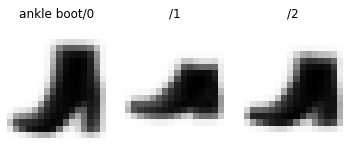

GMM-full (3) accuracy:  0.7494  [ 0.7536 on train]


In [11]:
ks=[1,3]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict() 
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full',eps=1e-3)
        if k==1:
            rs=[1]
        else:
            rs=[.05,.1,.25,1] 
        mmodels[y].trainFast(classData[y],verbose='final',rs=rs)
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        showMeans(mmodels,y)
        plt.show()
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    

Things to do:
- fill in the code to run the training above, which fits models with 1 and 3 Gaussian components, for both diagonal and full covariance matrices
- decide on any improvements/extensions to initialization, covariance matrix restrictions, convergence criteria, varying number of components across classes, etc., and try them out
- discuss trends you observe across settings, both in terms of train/val accuracy and in terms of the visualizations

| Model Type | Train Acc. | Validation Acc. |
| --- | --- | --- |
| 1 Gaussian Diag | 0.6890 | 0.6883 |
| 1 Gaussian Full | 0.6778 | 0.6737 |
| 3 Gaussian Diag | 0.7562 | 0.7503 |
| 3 Gaussian Full | 0.7536 | 0.7494 |

- The best model (from validation accuracy) is: 3 Gaussian with a diagonal covariance matrix. <br/>
- Corresponding best validation accuracy is 75.03%. <br/>
- In both cases the diagonal variance is better than the full variance matrix and 3 Gaussian components is better than 1. <br/>
- From the visualized cluster, in both cases diagonal produces better results than full covariance matrix. We also notice that 3 Gaussian case has a slightly lesser percentage of misclassification as compared to the 1 Gaussian case.